In [1]:
# import packages
from typing import List

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import beta
import numpy as np
import pandas as pd
from random import gauss

from src.change_detector.corrected_change_detector import PDFChangeDetector

In [2]:
%matplotlib ipympl

def plot_slider_animation(alpha_estimates_list, 
                        beta_estimates_list, 
                        min_u1s_list, 
                        min_u2s_list, 
                        min_u3s_list, 
                        current_u1s_list,
                        first_frame, last_frame,
                        y_min=0, y_max=100, x_min=0, x_max=0.3):
    
    framed_time=slice(first_frame, last_frame)
    
    frame_data_list = list(zip(alpha_estimates_list[framed_time], beta_estimates_list[framed_time],
                min_u1s_list[framed_time], min_u2s_list[framed_time], min_u3s_list[framed_time],
                current_u1s_list[framed_time], 
                range(first_frame, last_frame)))
    
    
    
    a_process, b_process, min_u1, min_u2, min_u3, current_u1, start_time = frame_data_list[0]
    end_time = frame_data_list[-1][-1]
    
    fig, ax = plt.subplots(figsize=(15,7))
    
    if (a_process is not None) and (b_process is not None):
        x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
        y_process = beta.pdf(x_process, a_process, b_process)
        line_process = ax.plot(x_process, y_process, 'b-', label='distance do reference distribution')[0]
    else:
        line_process = ax.plot([], [], 'b-', label='distance to reference distribution')[0]
    
    if current_u1 is not None:    
        u1_process = ax.axvline(current_u1, ymin=0, ymax= beta.pdf(current_u1, a_process, b_process), color="blue", linestyle="dashdot", label='current u1')
    else:
        u1_process = ax.axvline(0, ymin=0, ymax= 0, color="blue", linestyle="dashdot")
        
    if min_u1 is not None:    
        u1_marker = ax.plot([min_u1], [0], marker='^', markersize=12, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([min_u2], [0], marker='^', markersize=12, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([min_u3], [0], marker='^', markersize=12, color="red", alpha=0.5, label="u3_threshold")
    else:
        u1_marker = ax.plot([], [], marker='^', markersize=12, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([], [], marker='^', markersize=12, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([], [], marker='^', markersize=12, color="red", alpha=0.5, label="u3_threshold")
    
    ax.set(xlim=(x_min, x_max), xlabel='Values of Random Variable X (0, 1)',
        ylim=(y_min,y_max), ylabel='Probability density', title='Beta Distribution of pdf distances to reference distribution')
    time_legend = ax.text(0.9, 0.95, f'time: {start_time}', ha='left', va='top', transform=ax.transAxes,
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.legend(loc='lower right')

    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    freq_slider = Slider(
        ax=axfreq,
        label='Time step',
        valmin=start_time,
        valmax=end_time,
        valinit=start_time,
    )
        
    # Plot the beta distribution
    def update(val):
        
        idx = int(freq_slider.val-start_time)
        a_process, b_process, min_u1, min_u2, min_u3, current_u1, time = frame_data_list[idx]

        if (a_process is not None) and (b_process is not None):
            x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
            y_process = beta.pdf(x_process, a_process, b_process)
            line_process.set_data(x_process, y_process)
        else:
            line_process.set_data([], [])
            
        if current_u1 is not None:    
            u1_process.set_xdata([current_u1, current_u1])
            u1_process.set_ydata([0,beta.pdf(current_u1, a_process, b_process)])
        else:
            u1_process.set_xdata([0,0])
            u1_process.set_ydata([0,0])
            
        if min_u1 is not None:    
            u1_marker[0].set_xdata([min_u1])
            u1_marker[0].set_ydata([0])
            u2_marker[0].set_xdata([min_u2])
            u2_marker[0].set_ydata([0])
            u3_marker[0].set_xdata([min_u3])
            u3_marker[0].set_ydata([0])
        else:
            u1_marker[0].set_xdata([])
            u1_marker[0].set_ydata([])
            u2_marker[0].set_xdata([])
            u2_marker[0].set_ydata([])
            u3_marker[0].set_xdata([])
            u3_marker[0].set_ydata([])
        
        time_legend.set_text(f'time: {time}')
        
        fig.canvas.draw_idle()
        
    # register the update function with each slider
    freq_slider.on_changed(update)
    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')
    
    def reset(event):
        freq_slider.reset()
    
    button.on_clicked(reset)

    plt.show()

In [3]:
def gaussian_histogram(mu:float, sigma:float, sample_size:int):
    bin_edges = np.linspace(-10,10,21)
    histogram, _ = np.histogram([gauss(mu, sigma) for _ in range(sample_size)], bins=bin_edges, density=True)
    return pd.Series(histogram)

In [4]:
def run_analysis(base_process: List[pd.Series],
                novel_process: List[pd.Series],
                method:str):

    change_detector = PDFChangeDetector(reference_size=30, monitor_size=50 ,method=method)

    detection_status_list = []
    detection_status_value_list = []
    alpha_estimates_list = []
    beta_estimates_list = []
    u1_min_list = []
    u2_min_list = []
    u3_min_list = []
    current_u1_list = []

    for new_pdf in base_process:
        # new_pdf = gaussian_histogram(2, 1, 10000)
        detect_response = change_detector.detect_change(new_pdf)
        
        detection_status_list.append(detect_response.state.name)
        detection_status_value_list.append(detect_response.state.value)
        alpha_estimates_list.append(detect_response.alpha_estimate)
        beta_estimates_list.append(detect_response.beta_estimate)
        u1_min_list.append(detect_response.min_u1)
        u2_min_list.append(detect_response.min_u2)
        u3_min_list.append(detect_response.min_u3)
        current_u1_list.append(detect_response.current_u1)
        
        # print("Status: ", detect_response.state.name, 
        #     "| Alpha :", detect_response.alpha_estimate, 
        #     "| Beta", detect_response.beta_estimate, 
        #     "\n***\n")

    i=500
    for new_pdf in novel_process:
        # new_pdf = gaussian_histogram(2.1, 1, 10000)
        detect_response = change_detector.detect_change(new_pdf)
        
        if detect_response.state.name != detection_status_list[-1]:
            print("detection status changed from ", detection_status_list[-1], " to ", detect_response.state.name, " at time instance", i)
            print(detect_response.state.value)
        detection_status_list.append(detect_response.state.name)
        detection_status_value_list.append(detect_response.state.value)
        alpha_estimates_list.append(detect_response.alpha_estimate)
        beta_estimates_list.append(detect_response.beta_estimate)
        u1_min_list.append(detect_response.min_u1)
        u2_min_list.append(detect_response.min_u2)
        u3_min_list.append(detect_response.min_u3)
        current_u1_list.append(detect_response.current_u1)
        i+=1
        
        
        # print("Status: ", detect_response.state.name, 
        #     "| Alpha :", detect_response.alpha_estimate, 
        #     "| Beta", detect_response.beta_estimate, 
        #     "\n***\n")
        
    return {
        "detection_status_list": detection_status_list,
        "detection_status_value_list": detection_status_value_list,
        "alpha_estimates_list": alpha_estimates_list,
        "beta_estimates_list": beta_estimates_list,
        "u1_min_list": u1_min_list,
        "u2_min_list": u2_min_list,
        "u3_min_list": u3_min_list,
        "current_u1_list": current_u1_list
    }

In [5]:
hist_f = lambda mean, var : gaussian_histogram(mean, var, 2000)

In [6]:
test_context = {
    "base_interval": {
        "duration": 1000,
        "mean": 0,
        "var": 1,
        "histogram_function": hist_f
    },
    "test_mean_a":{
            "duration": 500,
            "mean": 2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_b":{
            "duration": 500,
            "mean": 1,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_c":{
            "duration": 500,
            "mean": 0.5,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_d":{
            "duration": 500,
            "mean": 0.2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_e":{
            "duration": 500,
            "mean": 0.05,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_var_a":{
            "duration": 500,
            "mean": 0,
            "var": 2,
            "histogram_function": hist_f
    },
    "test_var_b":{
            "duration": 500,
            "mean": 0,
            "var": 1.5,
            "histogram_function": hist_f
    },
    "test_var_c":{
            "duration": 500,
            "mean": 0,
            "var": 1.1,
            "histogram_function": hist_f
    },
    "test_var_d":{
            "duration": 500,
            "mean": 0,
            "var": 1.05,
            "histogram_function": hist_f
    },
   "test_var_e":{
            "duration": 500,
            "mean": 0,
            "var": 1.01,
            "histogram_function": hist_f
    },
}

In [7]:
np.random.seed(12345)

pdf_test_pdfs = {}

for key, value in test_context.items():
    print(key)
    print(value)
    pdf_test_pdfs[key] = [value["histogram_function"](value["mean"], value["var"]) for _ in range(value["duration"])]

base_interval
{'duration': 1000, 'mean': 0, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_mean_a
{'duration': 500, 'mean': 2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_mean_b
{'duration': 500, 'mean': 1, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_mean_c
{'duration': 500, 'mean': 0.5, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_mean_d
{'duration': 500, 'mean': 0.2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_mean_e
{'duration': 500, 'mean': 0.05, 'var': 1, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_var_a
{'duration': 500, 'mean': 0, 'var': 2, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_var_b
{'duration': 500, 'mean': 0, 'var': 1.5, 'histogram_function': <function <lambda> at 0x76059f3b2de0>}
test_var_c
{'duration': 500, 'mean': 0, 'var': 1.1, 'histogram_function': <function <lambda> a

In [8]:
test_list = [
    'test_mean_a',
    'test_mean_b',
    'test_mean_c',
    'test_mean_d',
    'test_mean_e',
    'test_var_a',
    'test_var_b',
    'test_var_c',
    'test_var_d',
    'test_var_e',]

In [9]:
test_results = {}

for test in test_list:
    print(f"performing {test} truncated")
    test_results[f"{test}_truncated"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "truncated"
    )
    print(f"{test} truncated done")
    print()
    print(f"performing {test} window")
    test_results[f"{test}_window"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "window"
    )
    print(f"{test} window done")
    print()

performing test_mean_a truncated
Out of control: Replacing current process with candidate process.
detection status changed from  IN_CONTROL  to  OUT_OF_CONTROL  at time instance 500
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 501
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a truncated done

performing test_mean_a window
Out of control: Replacing current process with candidate process.
detection status changed from  IN_CONTROL  to  OUT_OF_CONTROL  at time instance 500
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 501
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a window done

performing test_mean_b truncated
Out of control: Replacing current process with candidate process.
detection status changed from  IN_CONTROL  to  OUT_OF_CONTROL  at time instance 500
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at tim

In [10]:
df_mean_truncated = pd.DataFrame([test_results["test_mean_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_truncated.columns = ["2", "1", "0.5", "0.2", "0.05"]

In [11]:
df_mean_window = pd.DataFrame([test_results["test_mean_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_window.columns = ["2", "1", "0.5", "0.2", "0.05"]

In [12]:
df_var_truncated = pd.DataFrame([test_results["test_var_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_truncated.columns = ["2", "1.5", "1.1", "1.05", "1.01"]

In [13]:
df_var_window = pd.DataFrame([test_results["test_var_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_window.columns = ["2", "1.5", "1.1", "1.05", "1.01"]

In [14]:
import seaborn as sns
%matplotlib inline
from matplotlib.colors import BoundaryNorm, ListedColormap


In [15]:
def plot_status(dataframe:pd.DataFrame, title:str):
    fig, ax = plt.subplots(figsize=(15,3))

    my_colors = ['tab:olive', 'tab:orange', 'tab:red', 'tab:cyan']
    my_cmap = ListedColormap(my_colors)
    # my_norm = BoundaryNorm([0, 1, 2 , 3], my_cmap.N)

    ax = sns.heatmap(dataframe.T,
                    cmap=my_cmap,
                    #  norm = my_norm,
                    ax=ax)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([3/8+i*3/4 for i in range(4)])
    colorbar.set_ticklabels(['In-Control', 'Warning', 'Out-of-Control', 'Learning'])
    plt.title(title)
    plt.savefig(f"../images/analysis/{title}.png")
    plt.show()

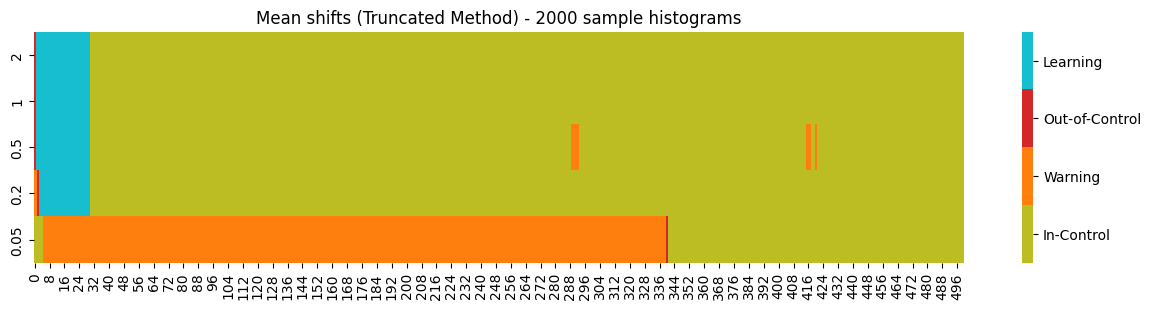

In [16]:
plot_status(df_mean_truncated, "Mean shifts (Truncated Method) - 2000 sample histograms")

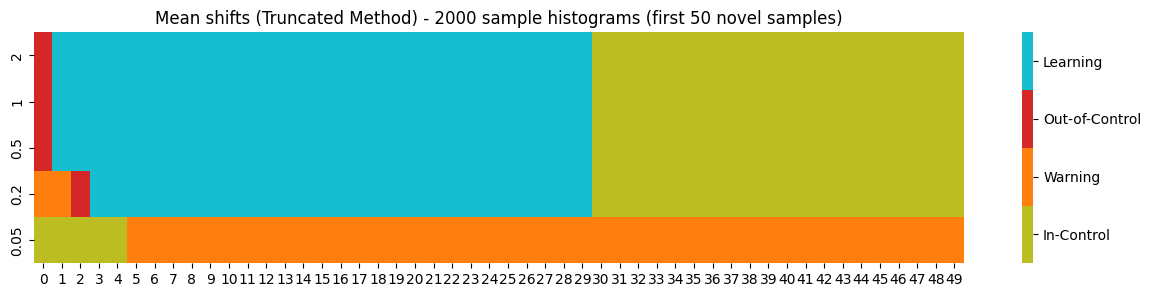

In [17]:
plot_status(df_mean_truncated[:50], "Mean shifts (Truncated Method) - 2000 sample histograms (first 50 novel samples)")

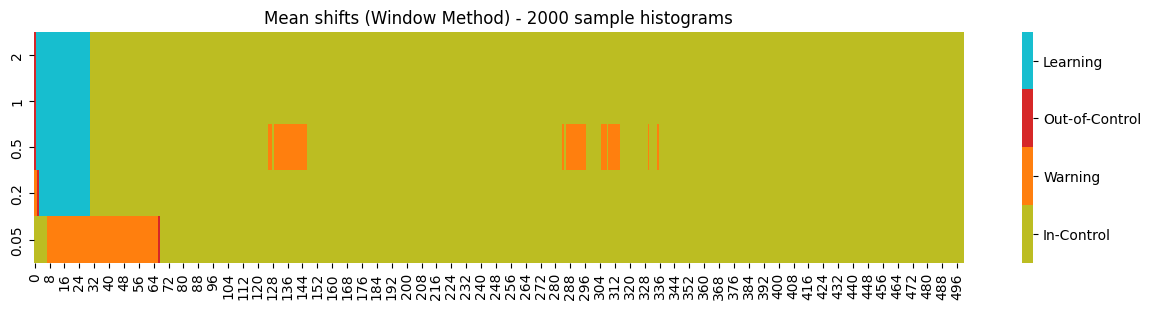

In [18]:
plot_status(df_mean_window, "Mean shifts (Window Method) - 2000 sample histograms")

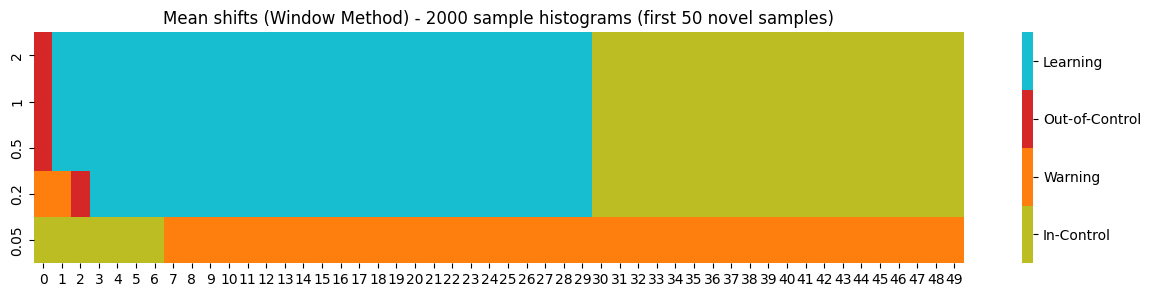

In [19]:
plot_status(df_mean_window[:50], "Mean shifts (Window Method) - 2000 sample histograms (first 50 novel samples)")

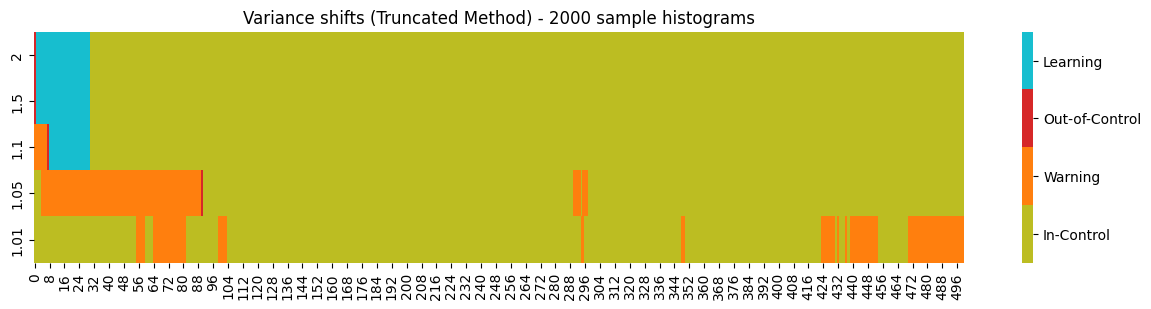

In [20]:
plot_status(df_var_truncated, "Variance shifts (Truncated Method) - 2000 sample histograms")

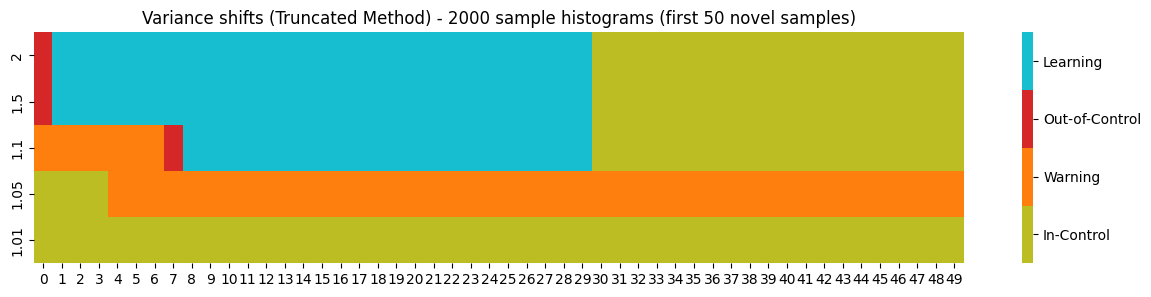

In [21]:
plot_status(df_var_truncated[:50], "Variance shifts (Truncated Method) - 2000 sample histograms (first 50 novel samples)")

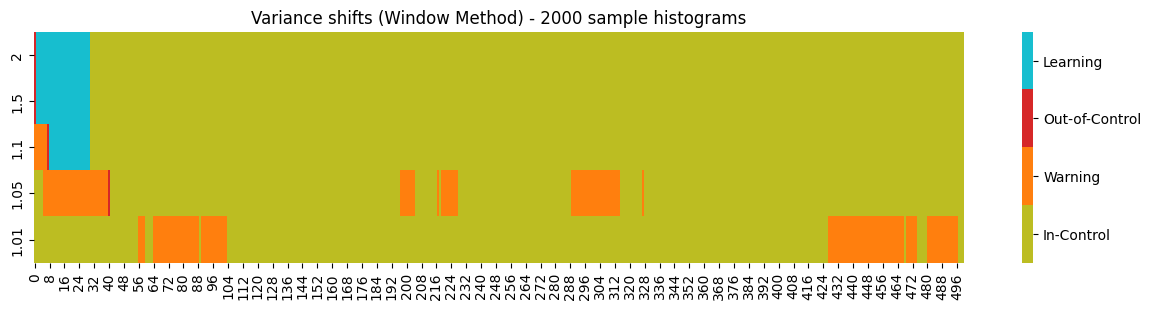

In [22]:
plot_status(df_var_window, "Variance shifts (Window Method) - 2000 sample histograms")

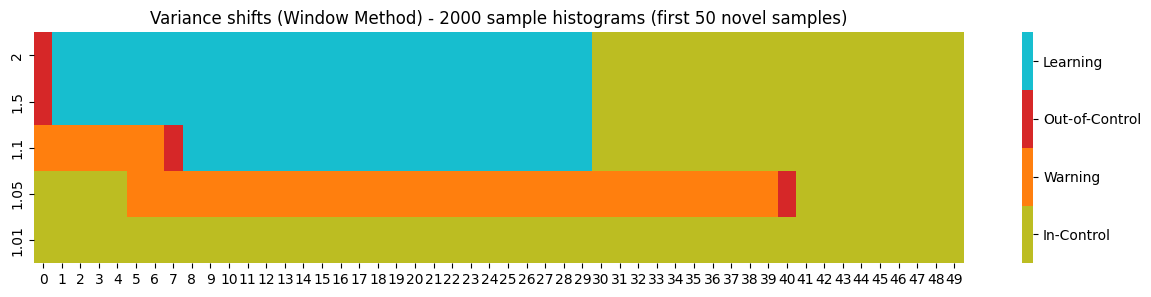

In [23]:
plot_status(df_var_window[:50], "Variance shifts (Window Method) - 2000 sample histograms (first 50 novel samples)")

In [24]:
hist_f = lambda mean, var : gaussian_histogram(mean, var, 200)

In [25]:
test_context = {
    "base_interval": {
        "duration": 1000,
        "mean": 0,
        "var": 1,
        "histogram_function": hist_f
    },
    "test_mean_a":{
            "duration": 500,
            "mean": 2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_b":{
            "duration": 500,
            "mean": 1,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_c":{
            "duration": 500,
            "mean": 0.5,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_d":{
            "duration": 500,
            "mean": 0.2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_e":{
            "duration": 500,
            "mean": 0.05,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_var_a":{
            "duration": 500,
            "mean": 0,
            "var": 2,
            "histogram_function": hist_f
    },
    "test_var_b":{
            "duration": 500,
            "mean": 0,
            "var": 1.5,
            "histogram_function": hist_f
    },
    "test_var_c":{
            "duration": 500,
            "mean": 0,
            "var": 1.1,
            "histogram_function": hist_f
    },
    "test_var_d":{
            "duration": 500,
            "mean": 0,
            "var": 1.05,
            "histogram_function": hist_f
    },
   "test_var_e":{
            "duration": 500,
            "mean": 0,
            "var": 1.01,
            "histogram_function": hist_f
    },
}

In [26]:
np.random.seed(12345)

pdf_test_pdfs = {}

for key, value in test_context.items():
    print(key)
    print(value)
    pdf_test_pdfs[key] = [ value["histogram_function"](value["mean"], value["var"]) for _ in range(value["duration"])]

base_interval
{'duration': 1000, 'mean': 0, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_mean_a
{'duration': 500, 'mean': 2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_mean_b
{'duration': 500, 'mean': 1, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_mean_c
{'duration': 500, 'mean': 0.5, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_mean_d
{'duration': 500, 'mean': 0.2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_mean_e
{'duration': 500, 'mean': 0.05, 'var': 1, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_var_a
{'duration': 500, 'mean': 0, 'var': 2, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_var_b
{'duration': 500, 'mean': 0, 'var': 1.5, 'histogram_function': <function <lambda> at 0x76059b9f93a0>}
test_var_c
{'duration': 500, 'mean': 0, 'var': 1.1, 'histogram_function': <function <lambda> a

In [27]:
test_list = [
    'test_mean_a',
    'test_mean_b',
    'test_mean_c',
    'test_mean_d',
    'test_mean_e',
    'test_var_a',
    'test_var_b',
    'test_var_c',
    'test_var_d',
    'test_var_e',]

In [28]:
test_results = {}

for test in test_list:
    print(f"performing {test} truncated")
    test_results[f"{test}_truncated"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "truncated"
    )
    print(f"{test} truncated done")
    print()
    print(f"performing {test} window")
    test_results[f"{test}_window"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "window"
    )
    print(f"{test} window done")
    print()

performing test_mean_a truncated
Out of control: Replacing current process with candidate process.
detection status changed from  IN_CONTROL  to  OUT_OF_CONTROL  at time instance 500
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 501
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a truncated done

performing test_mean_a window
Out of control: Replacing current process with candidate process.
detection status changed from  IN_CONTROL  to  OUT_OF_CONTROL  at time instance 500
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 501
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a window done

performing test_mean_b truncated
detection status changed from  IN_CONTROL  to  WARNING  at time instance 500
1
Out of control: Replacing current process with candidate process.
detection status changed from  WARNING  to  OUT_OF_CONTROL  at time instan

In [29]:
df_mean_truncated = pd.DataFrame([test_results["test_mean_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_truncated.columns =["2", "1", "0.5", "0.2", "0.05"]

In [30]:
df_mean_window = pd.DataFrame([test_results["test_mean_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_window.columns = ["2", "1", "0.5", "0.2", "0.05"]

In [31]:
df_var_truncated = pd.DataFrame([test_results["test_var_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_truncated.columns =["2", "1.5", "1.1", "1.05", "1.01"]

In [32]:
df_var_window = pd.DataFrame([test_results["test_var_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_window.columns = ["2", "1.5", "1.1", "1.05", "1.01"]

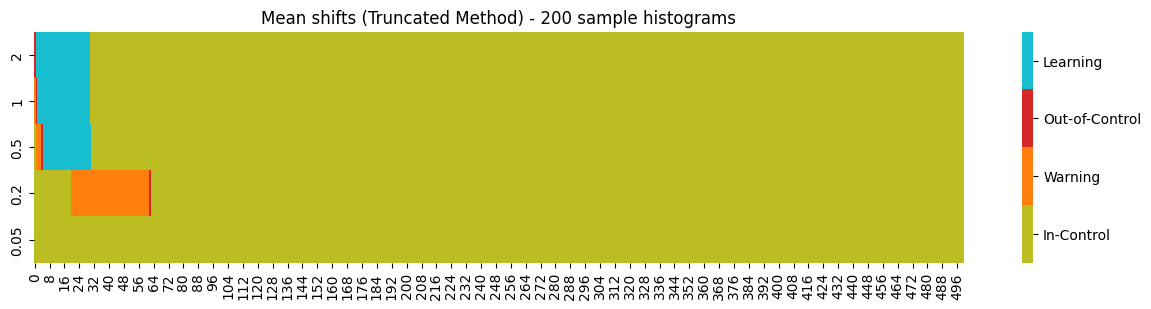

In [33]:
plot_status(df_mean_truncated, "Mean shifts (Truncated Method) - 200 sample histograms")

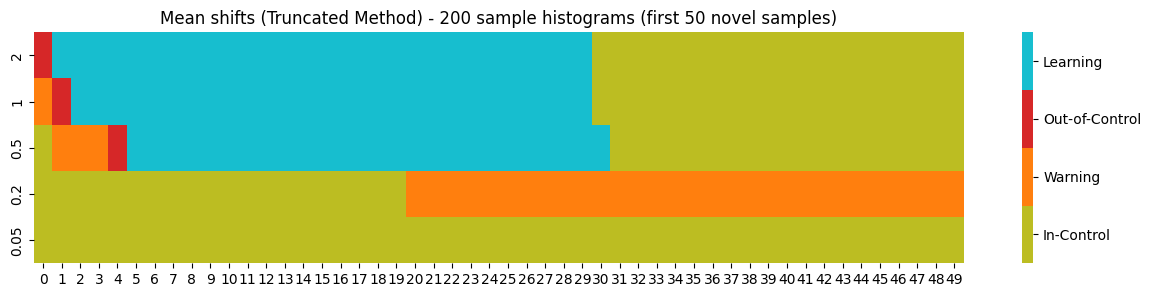

In [34]:
plot_status(df_mean_truncated[:50], "Mean shifts (Truncated Method) - 200 sample histograms (first 50 novel samples)")

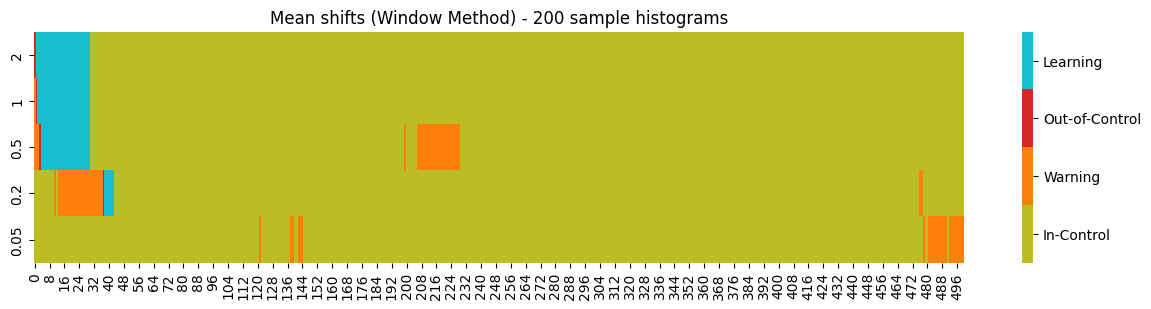

In [35]:
plot_status(df_mean_window, "Mean shifts (Window Method) - 200 sample histograms")

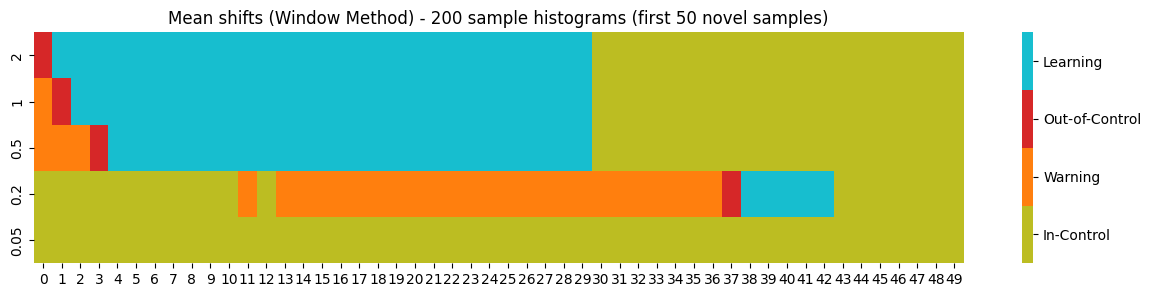

In [36]:
plot_status(df_mean_window[:50], "Mean shifts (Window Method) - 200 sample histograms (first 50 novel samples)")

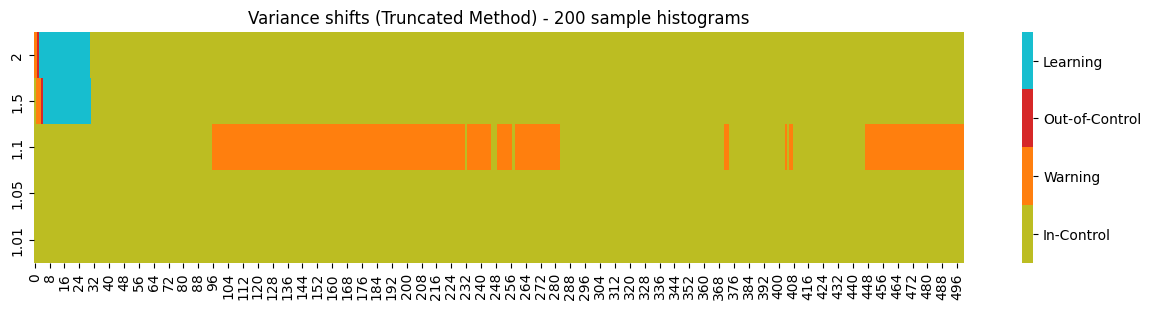

In [37]:
plot_status(df_var_truncated, "Variance shifts (Truncated Method) - 200 sample histograms")

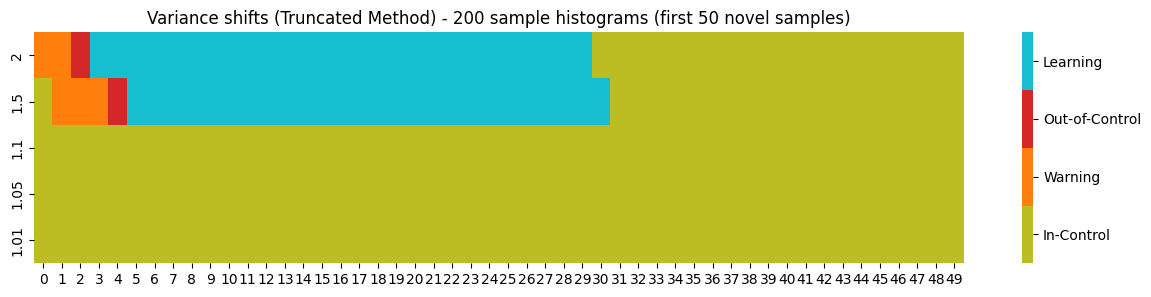

In [38]:
plot_status(df_var_truncated[:50], "Variance shifts (Truncated Method) - 200 sample histograms (first 50 novel samples)")

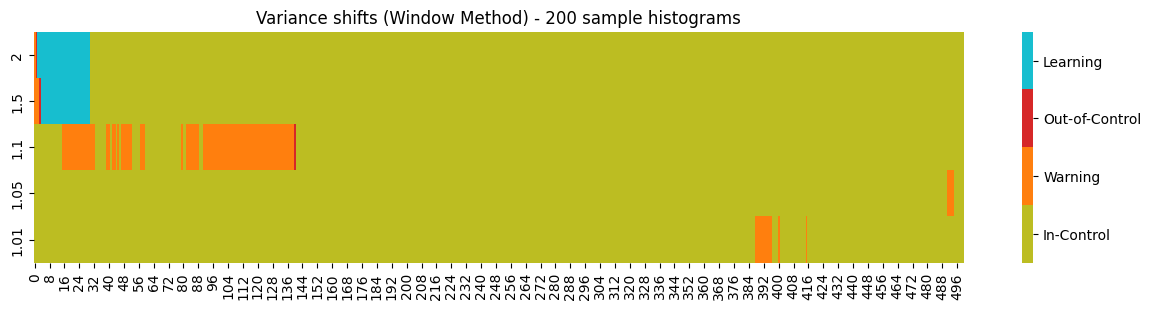

In [39]:
plot_status(df_var_window, "Variance shifts (Window Method) - 200 sample histograms")

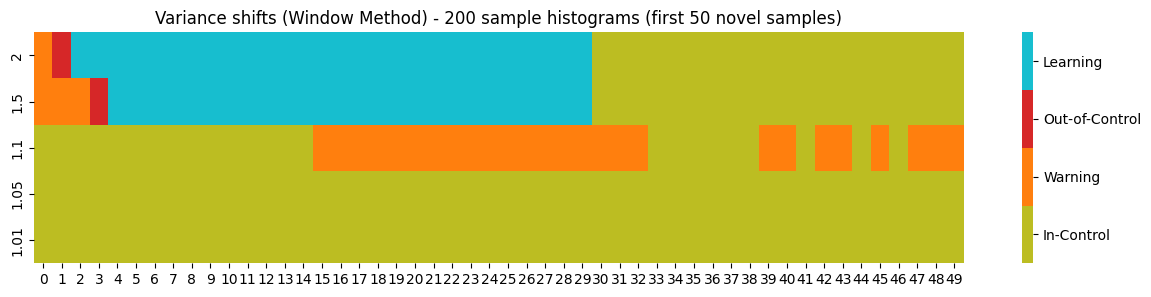

In [40]:
plot_status(df_var_window[:50], "Variance shifts (Window Method) - 200 sample histograms (first 50 novel samples)")

In [41]:
hist_f = lambda mean, var : gaussian_histogram(mean, var, 20)

In [42]:
test_context = {
    "base_interval": {
        "duration": 1000,
        "mean": 0,
        "var": 1,
        "histogram_function": hist_f
    },
    "test_mean_a":{
            "duration": 500,
            "mean": 2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_b":{
            "duration": 500,
            "mean": 1,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_c":{
            "duration": 500,
            "mean": 0.5,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_d":{
            "duration": 500,
            "mean": 0.2,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_mean_e":{
            "duration": 500,
            "mean": 0.05,
            "var": 1,
            "histogram_function": hist_f
    },
    "test_var_a":{
            "duration": 500,
            "mean": 0,
            "var": 2,
            "histogram_function": hist_f
    },
    "test_var_b":{
            "duration": 500,
            "mean": 0,
            "var": 1.5,
            "histogram_function": hist_f
    },
    "test_var_c":{
            "duration": 500,
            "mean": 0,
            "var": 1.1,
            "histogram_function": hist_f
    },
    "test_var_d":{
            "duration": 500,
            "mean": 0,
            "var": 1.05,
            "histogram_function": hist_f
    },
   "test_var_e":{
            "duration": 500,
            "mean": 0,
            "var": 1.01,
            "histogram_function": hist_f
    },
}

In [43]:
np.random.seed(12345)

pdf_test_pdfs = {}

for key, value in test_context.items():
    print(key)
    print(value)
    pdf_test_pdfs[key] = [ value["histogram_function"](value["mean"], value["var"]) for _ in range(value["duration"])]

base_interval
{'duration': 1000, 'mean': 0, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_mean_a
{'duration': 500, 'mean': 2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_mean_b
{'duration': 500, 'mean': 1, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_mean_c
{'duration': 500, 'mean': 0.5, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_mean_d
{'duration': 500, 'mean': 0.2, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_mean_e
{'duration': 500, 'mean': 0.05, 'var': 1, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_var_a
{'duration': 500, 'mean': 0, 'var': 2, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_var_b
{'duration': 500, 'mean': 0, 'var': 1.5, 'histogram_function': <function <lambda> at 0x76059eece160>}
test_var_c
{'duration': 500, 'mean': 0, 'var': 1.1, 'histogram_function': <function <lambda> a

In [44]:
test_list = [
    'test_mean_a',
    'test_mean_b',
    'test_mean_c',
    'test_mean_d',
    'test_mean_e',
    'test_var_a',
    'test_var_b',
    'test_var_c',
    'test_var_d',
    'test_var_e',]

In [45]:
test_results = {}

for test in test_list:
    print(f"performing {test} truncated")
    test_results[f"{test}_truncated"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "truncated"
    )
    print(f"{test} truncated done")
    print()
    print(f"performing {test} window")
    test_results[f"{test}_window"] = run_analysis(
        pdf_test_pdfs["base_interval"], pdf_test_pdfs[test], "window"
    )
    print(f"{test} window done")
    print()

performing test_mean_a truncated
detection status changed from  IN_CONTROL  to  WARNING  at time instance 500
1
Out of control: Replacing current process with candidate process.
detection status changed from  WARNING  to  OUT_OF_CONTROL  at time instance 502
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 503
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a truncated done

performing test_mean_a window
detection status changed from  IN_CONTROL  to  WARNING  at time instance 500
1
Out of control: Replacing current process with candidate process.
detection status changed from  WARNING  to  OUT_OF_CONTROL  at time instance 501
2
detection status changed from  OUT_OF_CONTROL  to  LEARNING  at time instance 502
3
detection status changed from  LEARNING  to  IN_CONTROL  at time instance 530
0
test_mean_a window done

performing test_mean_b truncated
detection status changed from  IN_CONTROL  to  WARNING  at time ins

In [46]:
df_mean_truncated = pd.DataFrame([test_results["test_mean_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_truncated.columns =["2", "1", "0.5", "0.2", "0.05"]

In [47]:
df_mean_window = pd.DataFrame([test_results["test_mean_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_mean_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_mean_window.columns = ["2", "1", "0.5", "0.2", "0.05"]

In [48]:
df_var_truncated = pd.DataFrame([test_results["test_var_a_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_truncated"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_truncated"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_truncated.columns =["2", "1.5", "1.1", "1.05", "1.01"]

In [49]:
df_var_window = pd.DataFrame([test_results["test_var_a_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_b_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_c_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_d_window"].get("detection_status_value_list")[1000:],
                                  test_results["test_var_e_window"].get("detection_status_value_list")[1000:]],
                                 
).T
df_var_window.columns = ["2", "1.5", "1.1", "1.05", "1.01"]

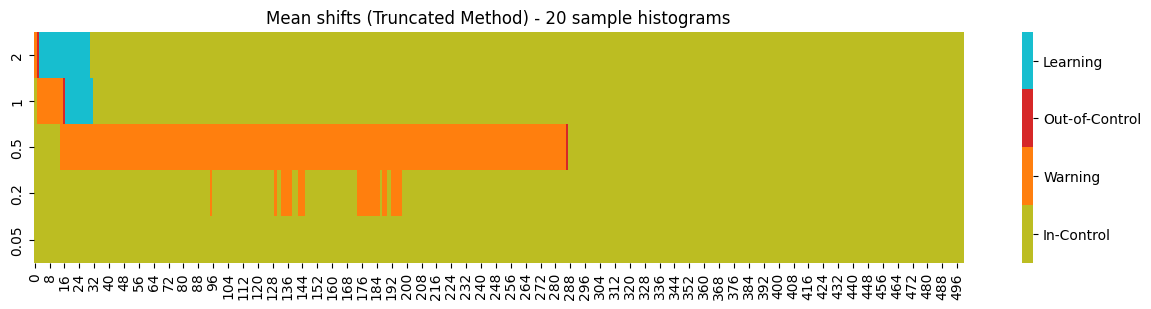

In [50]:
plot_status(df_mean_truncated, "Mean shifts (Truncated Method) - 20 sample histograms")

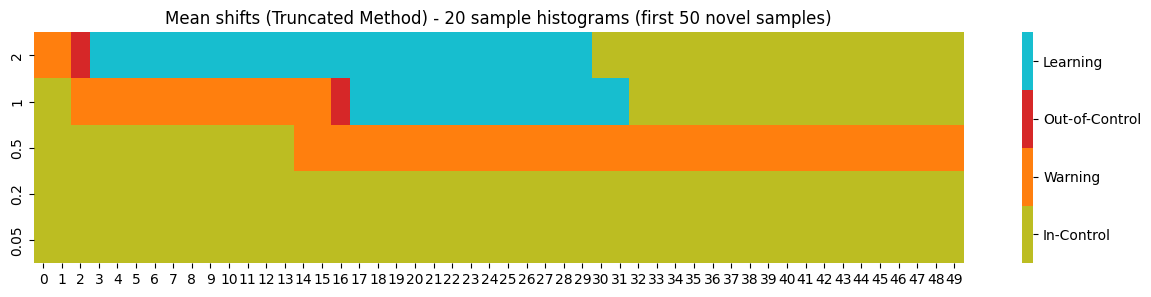

In [51]:
plot_status(df_mean_truncated[:50], "Mean shifts (Truncated Method) - 20 sample histograms (first 50 novel samples)")

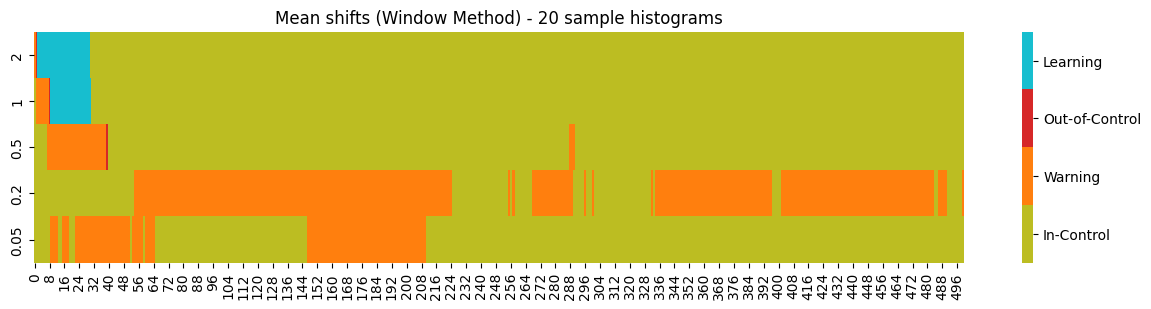

In [52]:
plot_status(df_mean_window, "Mean shifts (Window Method) - 20 sample histograms")

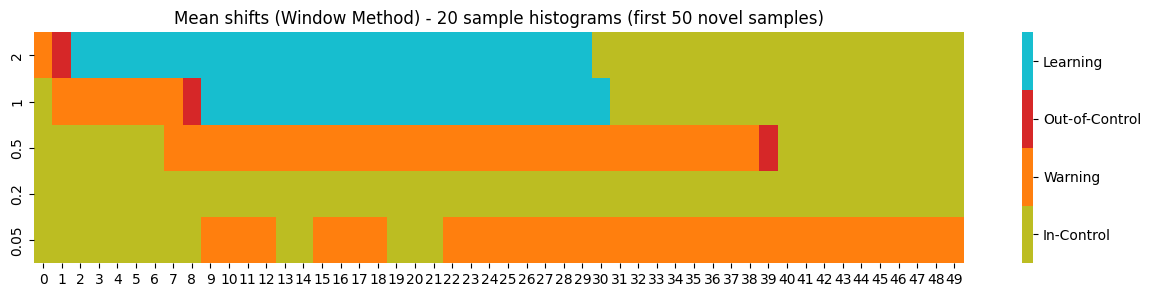

In [53]:
plot_status(df_mean_window[:50], "Mean shifts (Window Method) - 20 sample histograms (first 50 novel samples)")

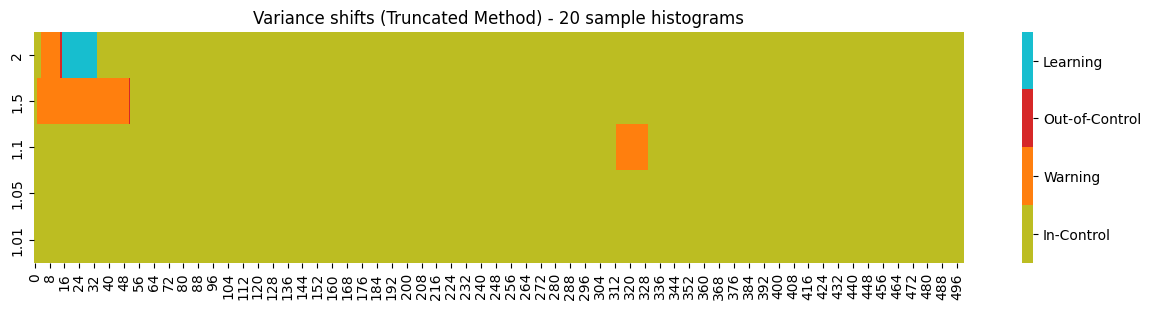

In [54]:
plot_status(df_var_truncated, "Variance shifts (Truncated Method) - 20 sample histograms")

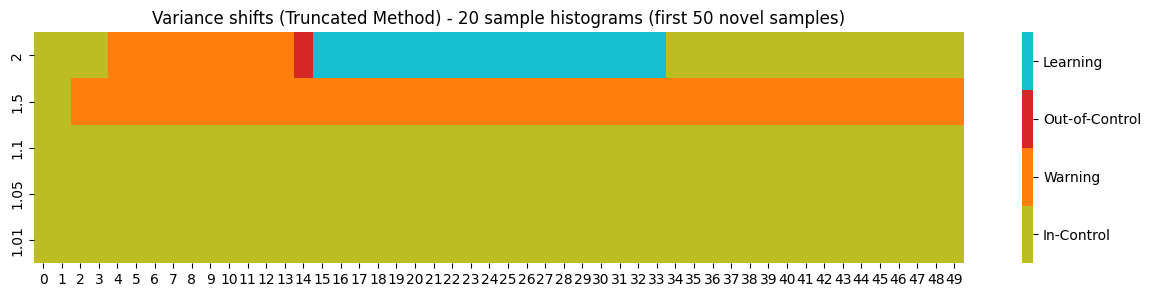

In [55]:
plot_status(df_var_truncated[:50], "Variance shifts (Truncated Method) - 20 sample histograms (first 50 novel samples)")

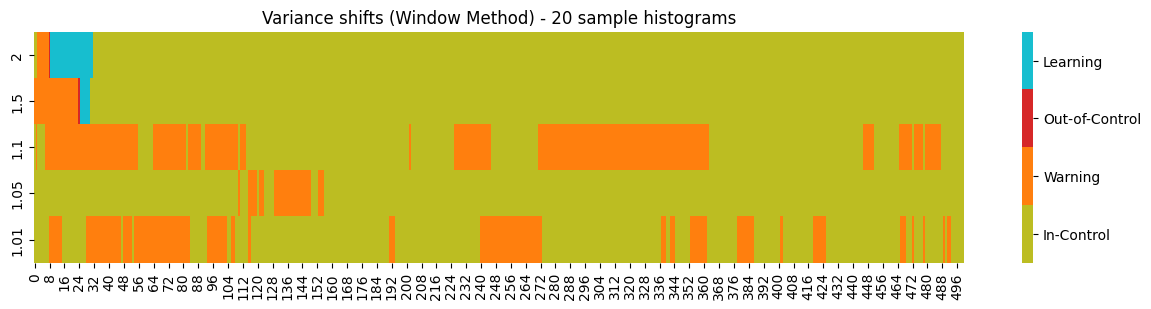

In [56]:
plot_status(df_var_window, "Variance shifts (Window Method) - 20 sample histograms")

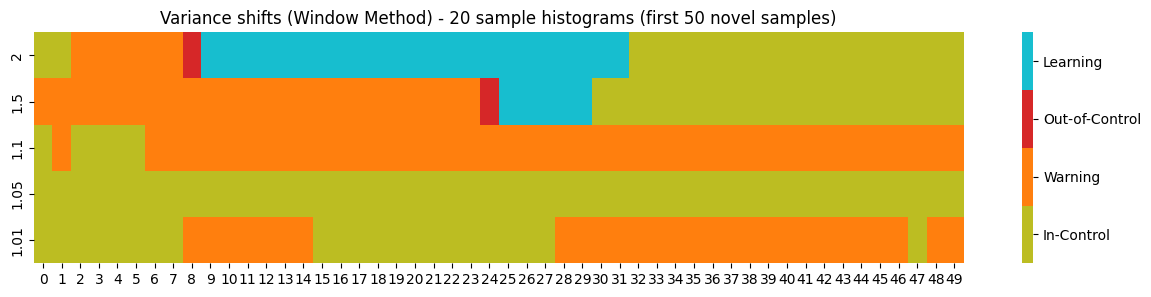

In [57]:
plot_status(df_var_window[:50], "Variance shifts (Window Method) - 20 sample histograms (first 50 novel samples)")

In [58]:
# Plot the gaussian distributions from where the sample pdf estimates are generated.
#

from turtle import color
from scipy.stats import norm

base_mean, base_var = 0, 1
mean_a, mean_b, mean_c, mean_d, mean_e = 2, 1, 0.5, 0.2, 0.05
var_a, var_b, var_c, var_d, var_e = 2, 1.5, 1.1, 1.05, 1.01

# Generate the value between
#
x_base = np.linspace(norm.ppf(.01, base_mean, base_var),norm.ppf(0.99, base_mean, base_var), 100)
x_mean_a = np.linspace(norm.ppf(.01, mean_a, base_var),norm.ppf(0.99, mean_a, base_var), 100)
x_mean_b = np.linspace(norm.ppf(.01, mean_b, base_var),norm.ppf(0.99, mean_b, base_var), 100)
x_mean_c = np.linspace(norm.ppf(.01, mean_c, base_var),norm.ppf(0.99, mean_c, base_var), 100)
x_mean_d = np.linspace(norm.ppf(.01, mean_d, base_var),norm.ppf(0.99, mean_d, base_var), 100)
x_mean_e = np.linspace(norm.ppf(.01, mean_e, base_var),norm.ppf(0.99, mean_e, base_var), 100)

x_var_a = np.linspace(norm.ppf(.01, base_mean, var_a),norm.ppf(0.99, base_mean, var_a), 100)
x_var_b = np.linspace(norm.ppf(.01, base_mean, var_b),norm.ppf(0.99, base_mean, var_b), 100)
x_var_c = np.linspace(norm.ppf(.01, base_mean, var_c),norm.ppf(0.99, base_mean, var_c), 100)
x_var_d = np.linspace(norm.ppf(.01, base_mean, var_d),norm.ppf(0.99, base_mean, var_d), 100)
x_var_e = np.linspace(norm.ppf(.01, base_mean, var_e),norm.ppf(0.99, base_mean, var_e), 100)


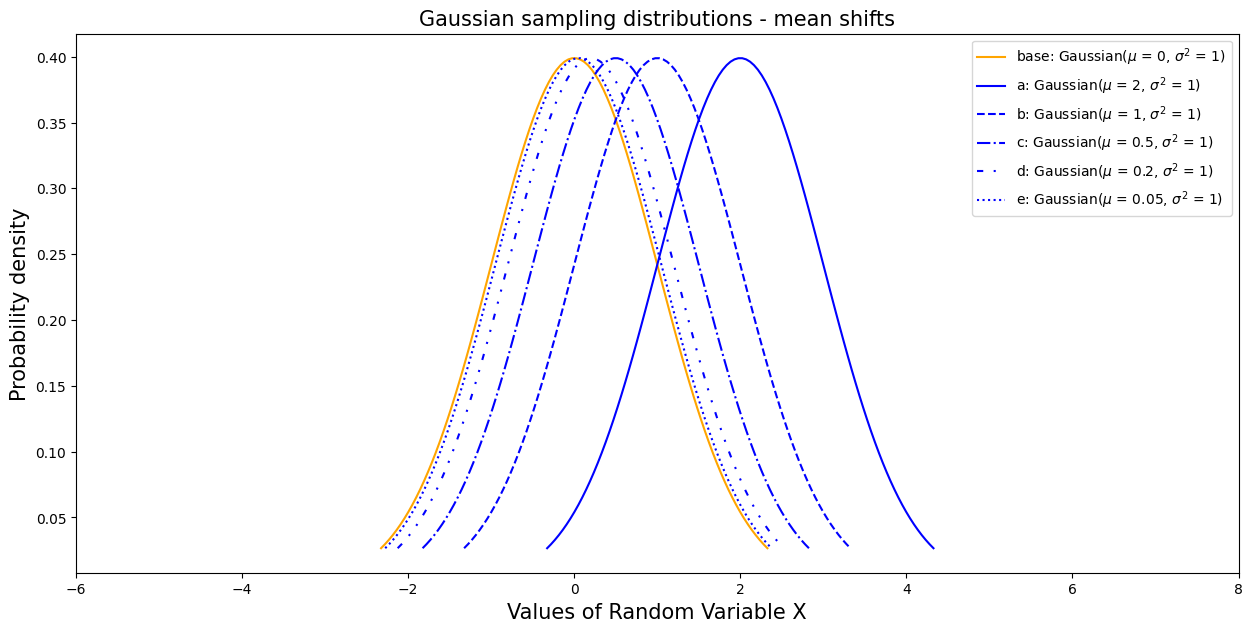

In [59]:

# Plot the sampling distribution
#
plt.figure(figsize=(15,7))
plt.xlim(-6, 8)
plt.plot(x_base, norm.pdf(x_base, base_mean, base_var), color='orange', linestyle='solid', label=r'base: Gaussian($\mu$ = 0, $\sigma^2$ = 1)')
plt.plot(x_mean_a, norm.pdf(x_mean_a, mean_a, base_var), color='blue', linestyle='solid', label=r'a: Gaussian($\mu$ = 2, $\sigma^2$ = 1)')
plt.plot(x_mean_b, norm.pdf(x_mean_b, mean_b, base_var), color='blue', linestyle='dashed', label=r'b: Gaussian($\mu$ = 1, $\sigma^2$ = 1)')
plt.plot(x_mean_c, norm.pdf(x_mean_c, mean_c, base_var), color='blue', linestyle='dashdot', label=r'c: Gaussian($\mu$ = 0.5, $\sigma^2$ = 1)')
plt.plot(x_mean_d, norm.pdf(x_mean_d, mean_d, base_var), color='blue', linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'd: Gaussian($\mu$ = 0.2, $\sigma^2$ = 1)')
plt.plot(x_mean_e, norm.pdf(x_mean_e, mean_e, base_var), color='blue', linestyle='dotted', label=r'e: Gaussian($\mu$ = 0.05, $\sigma^2$ = 1)')

plt.title('Gaussian sampling distributions - mean shifts', fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability density', fontsize='15')
plt.legend()
plt.show()

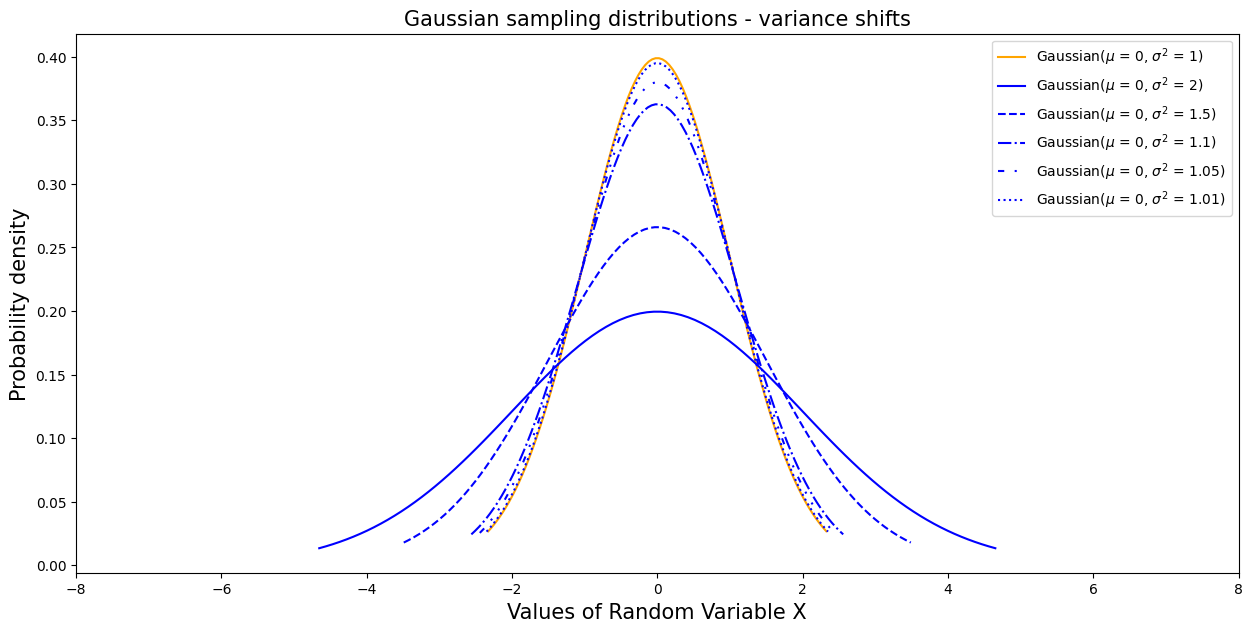

In [60]:
plt.figure(figsize=(15,7))
plt.xlim(-8, 8)
plt.plot(x_base, norm.pdf(x_base, base_mean, base_var), color='orange', linestyle='solid', label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 1)')
plt.plot(x_var_a, norm.pdf(x_var_a, base_mean, var_a), color='blue', linestyle='solid', label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 2)')
plt.plot(x_var_b, norm.pdf(x_var_b, base_mean, var_b), color='blue', linestyle='dashed', label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 1.5)')
plt.plot(x_var_c, norm.pdf(x_var_c, base_mean, var_c), color='blue', linestyle='dashdot', label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 1.1)')
plt.plot(x_var_d, norm.pdf(x_var_d, base_mean, var_d), color='blue', linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 1.05)')
plt.plot(x_var_e, norm.pdf(x_var_e, base_mean, var_e), color='blue', linestyle='dotted', label=r'Gaussian($\mu$ = 0, $\sigma^2$ = 1.01)')

plt.title('Gaussian sampling distributions - variance shifts', fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability density', fontsize='15')
plt.legend()
plt.show()